# Ensinando uma rede neural a jogar Flappy Bird

> Para esse tutorial é recomendado que seu python esteja com uma versãodo python igual ou inferior à 3.8.5, também será preciso as seguitnes bibliotecas: (para instalá-las é necessário que você tenha [git instalado](https://git-scm.com/downloads) em seu computador):

In [1]:
!pip install pygame
!pip install gym
!pip install git+https://github.com/GrupoTuring/PyGame-Learning-Environment
!pip install git+https://github.com/lusob/gym-ple

  Cloning https://github.com/GrupoTuring/PyGame-Learning-Environment to /tmp/pip-req-build-qy1iqx6r
  Running command git clone -q https://github.com/GrupoTuring/PyGame-Learning-Environment /tmp/pip-req-build-qy1iqx6r
  Created wheel for ple: filename=ple-0.0.2-cp36-none-any.whl size=723162 sha256=422392ef5e46c65ad81586b667f8d3049238b3bd8c44cbf5000fd427f31e3679
  Stored in directory: /tmp/pip-ephem-wheel-cache-zinm11xy/wheels/5b/b8/0e/ab7afe74867162d176c7d3991c02967becfbe5469089890c50
Successfully built ple
  Cloning https://github.com/lusob/gym-ple to /tmp/pip-req-build-4l562x6o
  Running command git clone -q https://github.com/lusob/gym-ple /tmp/pip-req-build-4l562x6o
  Created wheel for gym-ple: filename=gym_ple-0.3-cp36-none-any.whl size=5327 sha256=920b85d3cc145a0685cc39b454d998a8b0a7ce3ee59f6441f7b94b4a9db643e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlx_xbtx/wheels/95/71/23/9b8b2d8095d61cabe8ecb23c4141b53eaad8e7174cfbb414d3
Successfully built gym-ple


## Preparando e conhecendo nosso ambiente

In [ ]:
import gym_ple as gym

### Agente aleatório

**OBS: se você está rodando esse código np Google Collab você precisa comentar (adicionar #) no env.render()**

Vamos criar um agente aleatório para ver se está tudo certo com as bibliotecas:

In [1]:
env = gym.make("FlappyBird-v0")
env.reset()
obs = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]

while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    obs = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]
    env.render()
    if done:
        env.reset()
        obs = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]

Se o código rodar certinho, significa que tudo foi instalado corretamente

## Criando a IA

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import gym_ple
import gym
import numpy as np
import math
import datetime

pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


### Criando o Replay Buffer

In [3]:
class ReplayBuffer:

    def __init__(self, max_length, observation_space):
        self.index = 0
        self.size = 0
        self.max_length = max_length

        self.states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.actions = np.zeros((max_length), dtype=np.float32)
        self.rewards = np.zeros((max_length), dtype=np.float32)
        self.next_states = np.zeros((max_length, observation_space), dtype=np.float32)
        self.dones = np.zeros((max_length), dtype=np.float32)

    def __len__(self):
        return self.size

    def update(self, state, action, reward, next_state, done):
        self.states[self.index] = state
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.next_states[self.index] = next_state
        self.dones[self.index] = done

        self.index = (self.index + 1) % self.max_length
        if self.size < self.max_length:
            self.size += 1

    def sample(self, batch_size):
        indexes = np.random.randint(0, self.size, size=batch_size)

        return self.states[indexes], self.actions[indexes], self.rewards[indexes], self.next_states[indexes], \
               self.dones[indexes]

### Criando a rede neural

In [4]:
class LinearNetwork(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LinearNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

### Criando o agente

In [5]:
class DQNagent:

    def __init__(self,
                 observation_space,
                 action_space,
                 lr=3e-4,
                 gamma=0.9,
                 max_memory=10_000,
                 epsilon_init=0.5,
                 epsilon_decay=0.995,
                 epsilon_min=0.01,
                 epochs=1):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using {self.device}")
        self.gamma = gamma
        self.memory = ReplayBuffer(max_memory, observation_space.shape[0])
        self.action_space = action_space
        self.epochs = epochs

        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.dqn = LinearNetwork(observation_space.shape[0], action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

    def act(self, state):
        if np.random.random() < self.epsilon: #random action
            action = self.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(self.device)
                action = self.dqn.forward(state).argmax(dim=-1)
                action = action.cpu().numpy()

        return action

    def eps_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, new_state, done):
        self.memory.update(state, action, reward, new_state, done)

    def train(self, batch_size, save=False):
        if batch_size * 10 > self.memory.size:
            return

        for epoch in range(self.epochs):
            states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

            states = torch.as_tensor(states).to(self.device)
            actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
            rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
            next_states = torch.as_tensor(next_states).to(self.device)
            dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)

            q = self.dqn.forward(states).gather(-1, actions.long())

            with torch.no_grad():
                q2 = self.dqn.forward(next_states).max(dim=-1, keepdim=True)[0]

                target = (rewards + (1 - dones) * self.gamma *q2).to(self.device)

            loss = F.mse_loss(q, target)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if save:
            self.save_model()


    def save_model(self):
        filename = "models/DQN-" + str(env.unwrapped.spec.id) + '-' + datetime.datetime.now().strftime("%Y-%m-%d-%H%M")
        torch.save(self.dqn.state_dict(), filename)
        print(f"\n Model saved: {filename}")

    def load_model(self, PATH):
        self.dqn.load_state_dict(torch.load(PATH))
        print(f"Model loaded: {PATH}")

### Testando nosso agente

In [6]:
def train(agent, env, timesteps, batch_size, render=False):
    total_reward = 0
    episode_returns = deque(maxlen=20)
    avg_returns = []
    episode = 0
    env.reset()
    state = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]

    for timestep in range(1, timesteps + 1):
        action = agent.act(state)

        # Tomar a ação escolhida
        _, reward, done, info = env.step(action)
        next_state = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]

        # Guardar as informações geradas pela ação
        agent.remember(state, action, reward, next_state, done)

        # Treinar a rede com base no ReplayBuffer
        agent.train(batch_size, False)

        # Soma as recompensas
        total_reward += reward

        if done:
            episode_returns.append(total_reward)
            episode += 1
            env.reset()
            next_state = [v for _, v in sorted(env.unwrapped.game_state.getGameState().items())]

        agent.eps_decay()

        if episode_returns:
            avg_returns.append(np.mean(episode_returns))

        total_reward *= 1 - done
        ratio = math.ceil(100 * timestep / timesteps)
        avg_return = avg_returns[-1] if avg_returns else np.nan

        # Atualiza o estado
        state = next_state

        if render:
            # Mostra o ambiente
            env.render()

        print(
            f"\r[{ratio:3d}%]",
            f"timestep = {timestep}/{timesteps}",
            f"episode = {episode:3d}",
            f"avg_return = {avg_return:10.4f}",
            f"eps = {agent.epsilon:.4f}",
            sep=", ",
            end="")

    print()
    return avg_returns

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



Training DQN
Using cuda
[100%], timestep = 500000/500000, episode = 867, avg_return =    45.3500, eps = 0.0010

 Model saved: models/DQN-FlappyBird-v0-2021-01-23-1917


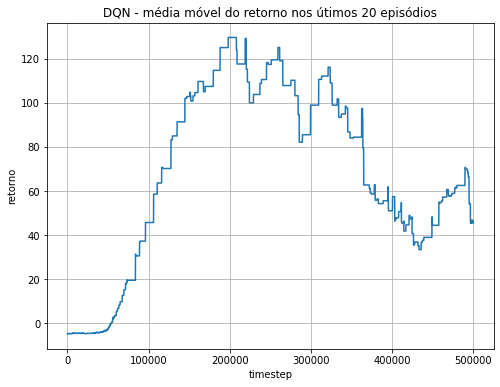

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_INIT = 0.5
EPS_END = 0.001
EPS_DECAY = 0.99995
MAX_MEMORY = 1_000_000
TIMESTEPS = 500_000
EPOCHS = 1

env_name = 'FlappyBird-v0'
env = gym.make(env_name)
OBS_SPACE = gym.spaces.Box(-np.inf, np.inf, shape=(len(env.unwrapped.game_state.getGameState()),))
ACT_SPACE = env.action_space

print("\nTraining DQN")
dqn_net = DQNagent(observation_space=OBS_SPACE,
                    action_space=ACT_SPACE,
                    lr=3e-4,
                    gamma=GAMMA,
                    max_memory=MAX_MEMORY,
                    epsilon_init=EPS_INIT,
                    epsilon_decay=EPS_DECAY,
                    epsilon_min=EPS_END,
                    epochs=EPOCHS)

results_dqn = train(dqn_net, env, TIMESTEPS, BATCH_SIZE, render=False)

dqn_net.save_model()

# Plota os resultados
plt.figure(figsize=(8,6))
plt.plot(results_dqn)
plt.title('DQN - média móvel do retorno nos útimos 20 episódios')
plt.xlabel('timestep')
plt.ylabel('retorno')
plt.grid()
plt.show()